In [45]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [46]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import matthews_corrcoef

# Preprocessing part

In [47]:
image_dir="/kaggle/input"

In [48]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def crop_brain_contour(image, plot=False):
    if len(image.shape) == 2:
        gray = image  
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


In [49]:
import os
import cv2
import numpy as np
from os import listdir

np.random.seed(32)

label_mapping = {
    '1': 'meningioma',
    '2': 'glioma',
    '3': 'pituitary tumor'
}

def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        label = os.path.basename(directory)  
        for filename in listdir(directory):
            image = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_COLOR)

            if image is None:
                print(f"Warning: Unable to load image at path {os.path.join(directory, filename)}")
                continue

            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append([label_mapping[label]])

    X = np.array(X)
    y = np.array(y)


    return X, y


In [50]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

image_dir_list = ["/kaggle/input/1", "/kaggle/input/2", "/kaggle/input/3"]

Images, Labels = load_data(image_dir_list, (IMG_WIDTH, IMG_HEIGHT))

In [51]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_CW = Labels.ravel()

classes = np.unique(y_train_CW)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_CW
)

class_weights_array = np.array(weights)



In [52]:
print(class_weights_array)

[0.71622253 1.44256121 1.09820789]


In [53]:
unique_labels = np.unique([label[0] for label in Labels])

label_to_int = {label: i for i, label in enumerate(unique_labels)}

one_hot_labels = np.zeros((len(Labels), len(unique_labels)))

for i, label in enumerate(Labels):
    label_text = label[0]
    label_index = label_to_int[label_text]
    one_hot_labels[i, label_index] = 1

In [54]:
print ("number of one_hot_labels  examples = " + str(one_hot_labels.shape))

number of one_hot_labels  examples = (3064, 3)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(Images, one_hot_labels, test_size=0.1 , random_state=42, stratify=one_hot_labels,shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train ,shuffle = True)


In [56]:
import random
from tensorflow.keras.backend import clear_session

clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [57]:
print ("number of training examples = " + str(X_train.shape))
print ("number of training labels examples = " + str(y_train.shape))
print ("number of test examples = " + str(X_test.shape))
print ("number of test labels examples = " + str(y_test.shape))

number of training examples = (2481, 224, 224, 3)
number of training labels examples = (2481, 3)
number of test examples = (307, 224, 224, 3)
number of test labels examples = (307, 3)


# Data augmentation

In [58]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
)

val_datagen = ImageDataGenerator()

datagen.fit(X_train)

val_datagen.fit(X_val)

train = datagen.flow(X_train, y_train, batch_size=8)

valid = val_datagen.flow(X_val, y_val, batch_size=8)

In [59]:
del X_train, y_train, X_val, y_val, one_hot_labels, unique_labels, label_to_int, Images, Labels, y_train_CW, classes, weights

# The Transformers functions

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization
from tensorflow.keras.activations import sigmoid



def window_partition(x, window_size):

    _, H, W, C = x.get_shape().as_list()

    patch_num_H = H // window_size
    patch_num_W = W // window_size
    x = tf.reshape(x, shape=(-1, patch_num_H, window_size, patch_num_W, window_size, C))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))

    windows = tf.reshape(x, shape=(-1, window_size, window_size, C))

    return windows


def window_reverse(windows, window_size, H, W, C):
    patch_num_H = H // window_size
    patch_num_W = W // window_size
    x = tf.reshape(windows, shape=(-1, patch_num_H, patch_num_W, window_size, window_size, C))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))

    x = tf.reshape(x, shape=(-1, H, W, C))

    return x


class Mlp(tf.keras.layers.Layer):
    def __init__(self, filter_num, drop=0., prefix='', **kwargs):
        super(Mlp, self).__init__(**kwargs)

        self.prefix = prefix
        self.filter_num = filter_num
        self.drop = drop

        self.fc1 = Dense(filter_num[0], name='{}_mlp_0'.format(prefix))
        self.fc2 = Dense(filter_num[1], name='{}_mlp_1'.format(prefix))
        self.drop = Dropout(drop)

        self.activation = tf.keras.activations.gelu

    def get_config(self):
        return {
            'prefix': self.prefix,
            'filter_num': self.filter_num,
            'drop': self.drop

        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x):
        x = self.fc1(x)
        self.activation(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0, proj_drop=0., prefix='',
                 **kwargs):
        super(WindowAttention, self).__init__(**kwargs)

        self.dim = dim  
        self.window_size = window_size  
        self.num_heads = num_heads  

        head_dim = dim // num_heads
        self.qk_scale = qk_scale
        self.qkv_bias = qkv_bias
        self.scale = qk_scale or head_dim ** -0.5  
        self.prefix = prefix
        self.attn_drop = attn_drop
        self.qkv = Dense(dim * 3, use_bias=qkv_bias, name='{}_attn_qkv'.format(self.prefix))
        self.attn_drops = Dropout(attn_drop)
        self.projs = Dense(dim, name='{}_attn_proj'.format(self.prefix))
        self.proj_drop = proj_drop
        self.proj_drops = Dropout(proj_drop)

    def get_config(self):

        return {
            'dim': self.dim,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'scale': self.scale,
            'qkv': self.qkv,
            'qk_scale': self.qk_scale,
            'qkv_bias': self.qkv_bias,
            'prefix': self.prefix,
            'attn_drop': self.attn_drop,
            'proj_drop': self.proj_drop,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def build(self, input_shape):

        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight('{}_attn_pos'.format(self.prefix),
                                                            shape=(num_window_elements, self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing='ij')
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False,
            name='{}_attn_pos_ind'.format(self.prefix))

        self.built = True

    def call(self, x, mask=None):

        _, N, C = x.get_shape().as_list()
        head_dim = C // self.num_heads

        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]

        q = q * self.scale

        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = (q @ k)

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias,
                                            shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=(-1, nW, self.num_heads, N, N)) + mask_float
            attn = tf.reshape(attn, shape=(-1, self.num_heads, N, N))
            attn = sigmoid(attn)
        else:
            attn = sigmoid(attn)

        attn = self.attn_drops(attn)

        x_qkv = (attn @ v)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, C))

        x_qkv = self.projs(x_qkv)

        x_qkv = self.proj_drops(x_qkv)

        return x_qkv


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_patch, num_heads, window_size=7, shift_size=0, num_mlp=1024,
                 qkv_bias=True, qk_scale=None, mlp_drop=0, attn_drop=0, proj_drop=0, drop_path_prob=0, prefix='',
                 **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)

        self.dim = dim  
        self.num_patch = num_patch  
        self.num_heads = num_heads 
        self.window_size = window_size  
        self.shift_size = shift_size  
        self.num_mlp = num_mlp  
        self.prefix = prefix
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.mlp_drop = mlp_drop
        self.attn_drop = attn_drop
        self.drop_path_prob = drop_path_prob

        self.norm1 = LayerNormalization(epsilon=1e-5, name='{}_norm1'.format(self.prefix))
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop,
                                    prefix=self.prefix)
        self.drop_path = drop_path(drop_path_prob)
        self.norm2 = LayerNormalization(epsilon=1e-5, name='{}_norm2'.format(self.prefix))
        self.mlp = Mlp([num_mlp, dim], drop=mlp_drop, prefix=self.prefix)

        assert 0 <= self.shift_size, 'shift_size >= 0 is required'
        assert self.shift_size < self.window_size, 'shift_size < window_size is required'

      
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def get_config(self):

        return {
            'dim': self.dim,
            'num_patch': self.num_patch,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'shift_size': self.shift_size,
            'num_mlp': self.num_mlp,
            'prefix': self.prefix,
            'qkv_bias': self.qkv_bias,
            'qk_scale': self.qk_scale,
            'mlp_drop': self.mlp_drop,
            'attn_drop': self.attn_drop,
            'drop_path_prob': self.drop_path_prob,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.num_patch
            h_slices = (
            slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (
            slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))

            mask_array = np.zeros((1, H, W, 1))

            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False,
                                         name='{}_attn_mask'.format(self.prefix))
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()

        assert L == H * W, 'Number of patches before and after Swin-MSA are mismatched.'

        x_skip = x

        x = self.norm1(x)

        x = tf.reshape(x, shape=(-1, H, W, C))

        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, C))

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, C))
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, H * W, C))

        x = self.drop_path(x)

        x = x_skip + x

        x_skip = x

        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)

        x = x_skip + x

        return x

In [61]:

from __future__ import absolute_import

import tensorflow as tf
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Conv2D, Layer, Dense, Embedding

class patch_extract(Layer):
    def __init__(self, patch_size, **kwargs):
        super(patch_extract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def get_config(self):
        return {
            'patch_size': self.patch_size
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        patch_height = self.patch_size
        patch_width = self.patch_size

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, patch_height, patch_width, 1],
            strides=[1, patch_height, patch_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )

        patch_dim = patches.shape[-1]
        patch_num = tf.shape(patches)[1] * tf.shape(patches)[2]

        patches = tf.reshape(patches, (batch_size, patch_num, patch_dim))
        return patches


class patch_embedding(Layer):
    def __init__(self, num_patch, embed_dim,**kwargs):
        super(patch_embedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.proj = Dense(self.embed_dim)
        self.pos_embed = Embedding(input_dim=num_patch, output_dim=self.embed_dim)

    def get_config(self):


        return {
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        embed = self.proj(patch) + self.pos_embed(pos)
        return embed

class patch_merging(tf.keras.layers.Layer):

    def __init__(self, num_patch, embed_dim, name='',**kwargs):
        super(patch_merging,self).__init__(**kwargs)

        self.num_patch = num_patch
        self.embed_dim = embed_dim

        self.linear_trans = Dense(2*embed_dim, use_bias=False, name='{}_linear_trans'.format(name))

    def get_config(self):

        return {
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


    def call(self, x):

        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()

        assert (L == H * W), 'input feature has wrong size'
        assert (H % 2 == 0 and W % 2 == 0), '{}-by-{} patches received, they are not even.'.format(H, W)

        x = tf.reshape(x, shape=(-1, H, W, C))

        x0 = x[:, 0::2, 0::2, :]  
        x1 = x[:, 1::2, 0::2, :]  
        x2 = x[:, 0::2, 1::2, :]  
        x3 = x[:, 1::2, 1::2, :]  
        x = tf.concat((x0, x1, x2, x3), axis=-1)

        x = tf.reshape(x, shape=(-1, (H//2)*(W//2), 4*C))

        x = self.linear_trans(x)

        return x

class patch_expanding(tf.keras.layers.Layer):

    def __init__(self, num_patch, embed_dim, upsample_rate, return_vector=True, name=''):
        super().__init__()

        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.upsample_rate = upsample_rate
        self.return_vector = return_vector

        self.linear_trans1 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        self.linear_trans2 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        self.prefix = name

    def call(self, x):

        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()

        assert (L == H * W), 'input feature has wrong size'

        x = tf.reshape(x, (-1, H, W, C))

        x = self.linear_trans1(x)

        x = tf.nn.depth_to_space(x, self.upsample_rate, data_format='NHWC', name='{}_d_to_space'.format(self.prefix))

        if self.return_vector:
            x = tf.reshape(x, (-1, L*self.upsample_rate*self.upsample_rate, C//2))

        return x

In [62]:

from __future__ import absolute_import

import tensorflow as tf
from tensorflow.keras.layers import Layer

def drop_path_(inputs, drop_prob, is_training):

    if (not is_training) or (drop_prob == 0.):
        return inputs

    keep_prob = 1.0 - drop_prob

    input_shape = tf.shape(inputs)
    batch_num = input_shape[0]; rank = len(input_shape)

    shape = (batch_num,) + (1,) * (rank - 1)
    random_tensor = keep_prob + tf.random.uniform(shape, dtype=inputs.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * path_mask
    return output

class drop_path(Layer):
    def __init__(self, drop_prob=None,**kwargs):
        super().__init__()
        self.drop_prob = drop_prob

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'drop_prob': self.drop_prob
        })
        return config


    def call(self, x, training=None):
        return drop_path_(x, self.drop_prob, training)

# VIT model checkpoint

In [63]:
from keras.callbacks import ModelCheckpoint


In [64]:
model_checkpoint_filepath_VIT = os.path.join('model_saved', 'best_model_VIT.Keras')


model_checkpoint_VIT = ModelCheckpoint(
    filepath=model_checkpoint_filepath_VIT, 
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Define learning rate reduction

In [65]:
learning_rate_reduction_VIT = ReduceLROnPlateau( monitor='val_loss', factor=0.2, epsilon=0.00001, patience=7,
                                                 verbose=1)

#  Define the early stoping

In [66]:
from keras.callbacks import EarlyStopping


In [67]:
early_VIT = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10, verbose=1)

In [68]:
callbacks_list_VIT = [early_VIT, learning_rate_reduction_VIT ,model_checkpoint_VIT]

#  Creating the feature extarcting model

#  Ensemble pretraind network

In [69]:
#  build our Ensemble network -- this is the pretrained

pretrained_D = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), weights='imagenet',  include_top=False)
#pretrained_E = tf.keras.applications.EfficientNetB7(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
#pretrained_VGG = tf.keras.applications.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

pretrained_googleNet = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

pretrained_IRV2 = tf.keras.applications.InceptionResNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
#pretrained_Xception = tf.keras.applications.Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


In [70]:

# Combining the models
for layer in pretrained_D.layers:
    layer.trainable = False

for layer in pretrained_IRV2.layers:
    layer.trainable = False

#for layer in pretrained_Xception.layers:
 #   layer.trainable = False

#for layer in pretrained_E.layers:
 #   layer.trainable = False

#for layer in pretrained_VGG.layers:
 #   layer.trainable = False

for layer in pretrained_googleNet.layers:
    layer.trainable = False

In [71]:
visible = tf.keras.layers.Input(shape=(224, 224,3))

#x4 = pretrained_E(visible)
#x3 = pretrained_VGG(visible)
x2 = pretrained_googleNet(visible)

x1 = pretrained_D(visible)
x5 = pretrained_IRV2(visible)
#x6 = pretrained_Xception(visible)

In [72]:
print(x2.shape)
print(x1.shape)
print(x5.shape)

(None, 5, 5, 2048)
(None, 7, 7, 1920)
(None, 5, 5, 1536)


In [73]:
x2 = tf.keras.layers.ZeroPadding2D(padding=((0, 2), (0, 2)))(x2)
x5 = tf.keras.layers.ZeroPadding2D(padding=((0, 2), (0, 2)))(x5)
#merge = tf.keras.layers.concatenate([x1, x5, x6], name="concatallprobs")
merge = tf.keras.layers.concatenate([x2,x1,x5], name="concatallprobs")


In [74]:
part_A = tf.keras.layers.ZeroPadding2D(padding=((0, 5), (0, 5)))(merge)

In [75]:
print(part_A.shape)

(None, 12, 12, 5504)


In [76]:
from keras.layers import GlobalAveragePooling1D

In [77]:

input_size = (12, 12, 5504)
patch_size = (2, 2)  

# Dropout parameters
mlp_drop_rate =  0.29963209507789 
attn_drop_rate = 0.760571445127933 
proj_drop_rate = 0.585595153449124 
drop_path_rate = 0.4789267873576293 

num_heads =4 
embed_dim = 96 
num_mlp =24 
qkv_bias = True  
qk_scale = None  
window_size = 2  
shift_size = window_size // 2  

num_patch_x = input_size[0] // patch_size[0]
num_patch_y = input_size[1] // patch_size[1]

patch_size = patch_size[0]
X = patch_extract(patch_size)(part_A)
X = patch_embedding(num_patch_x * num_patch_y, embed_dim)(X)

for i in range(2):
    if i % 2 == 0:
        shift_size_temp = 0
    else:
        shift_size_temp = shift_size

    X = SwinTransformerBlock(dim=embed_dim, num_patch=(num_patch_x, num_patch_y), num_heads=num_heads,
                                         window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate,
                                         drop_path_prob=drop_path_rate,
                                         prefix='swin_block{}'.format(i))(X)

X = patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
X = GlobalAveragePooling1D(name="feature_extracting_layer")(X)
X = tf.keras.layers.Dense(256, activation="relu", name="dense_head1")(X)
X = tf.keras.layers.Dropout(0.5, name="dropout_head1")(X)

X = tf.keras.layers.Dense(96, activation="relu", name="dense_head2")(X)
X = tf.keras.layers.Dropout(0.1, name="dropout_head2")(X)


OUT = Dense(3, activation='softmax', name="predictions_head")(X)


model = Model(inputs=visible, outputs=OUT)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.2), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



# Training the feature extracting model

In [78]:
history = model.fit(train, epochs=100,validation_data=valid, callbacks=callbacks_list_VIT, verbose=1)

Epoch 1/100
311/311 [==============================] - 745s 1s/step - loss: 1.2938 - accuracy: 0.4917 - val_loss: 0.4245 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 2/100
311/311 [==============================] - 434s 1s/step - loss: 0.6036 - accuracy: 0.7723 - val_loss: 0.1271 - val_accuracy: 0.9601 - lr: 1.0000e-04
Epoch 3/100
311/311 [==============================] - 152s 488ms/step - loss: 0.4269 - accuracy: 0.8561 - val_loss: 0.3286 - val_accuracy: 0.8877 - lr: 1.0000e-04
Epoch 4/100
311/311 [==============================] - 152s 487ms/step - loss: 0.2930 - accuracy: 0.9077 - val_loss: 2.1565 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 5/100
311/311 [==============================] - 152s 487ms/step - loss: 0.2241 - accuracy: 0.9295 - val_loss: 0.2952 - val_accuracy: 0.9130 - lr: 1.0000e-04
Epoch 6/100
311/311 [==============================] - 160s 515ms/step - loss: 0.1924 - accuracy: 0.9391 - val_loss: 0.1315 - val_accuracy: 0.9674 - lr: 1.0000e-04
Epoch 7/100
311/311 [=

In [79]:
print("Loss of the model is - " , model.evaluate(X_test, y_test)[0])

print("Accuracy of the model is - " , model.evaluate(X_test, y_test)[1]*100 , "%")

10/10 [==============================] - 15s 2s/step - loss: 0.0738 - accuracy: 0.9935
Loss of the model is -  0.07382319867610931
10/10 [==============================] - 4s 405ms/step - loss: 0.0738 - accuracy: 0.9935
Accuracy of the model is -  99.34853315353394 %


Text(0.5, 0, 'Epochs')

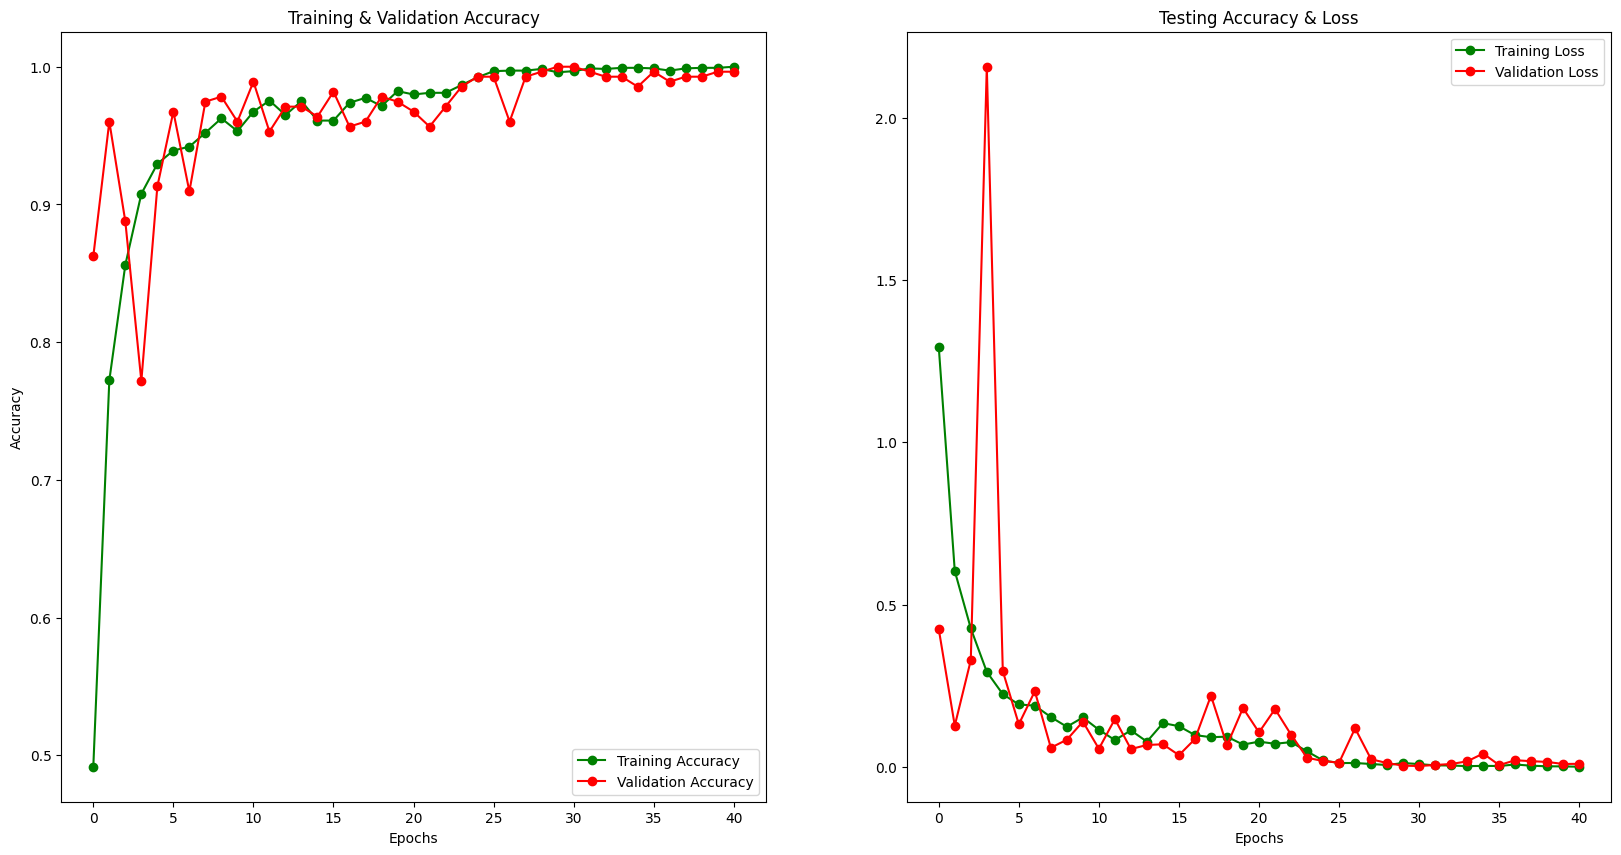

In [80]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")


In [81]:
preds_VIT = model.predict(X_test, verbose=0)

In [82]:
y_test_ground_truth = np.argmax(y_test, axis=1)

In [84]:
predictions_VIT = np.argmax(preds_VIT, axis=1)



In [85]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_ground_truth, predictions_VIT, target_names=[' meningioma (Class 0)', ' glioma (Class 1)', 'pituitary tumor(Class 2)'], digits = 4))

Classification Report:
                          precision    recall  f1-score   support

    meningioma (Class 0)     0.9930    0.9930    0.9930       143
        glioma (Class 1)     0.9859    0.9859    0.9859        71
pituitary tumor(Class 2)     1.0000    1.0000    1.0000        93

                accuracy                         0.9935       307
               macro avg     0.9930    0.9930    0.9930       307
            weighted avg     0.9935    0.9935    0.9935       307



In [86]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(y_test_ground_truth, predictions_VIT, labels=[0, 1, 2]), index=["Actual meningioma", "Actual glioma", "Actual pituitary tumor"],columns=["Predicted meningioma", "Predicted glioma", "Predicted pituitary tumor"])
cm

Predicted meningioma  Predicted glioma  \
Actual meningioma                        142                 1   
Actual glioma                              1                70   
Actual pituitary tumor                     0                 0   

                        Predicted pituitary tumor  
Actual meningioma                               0  
Actual glioma                                   0  
Actual pituitary tumor                         93

<Axes: >

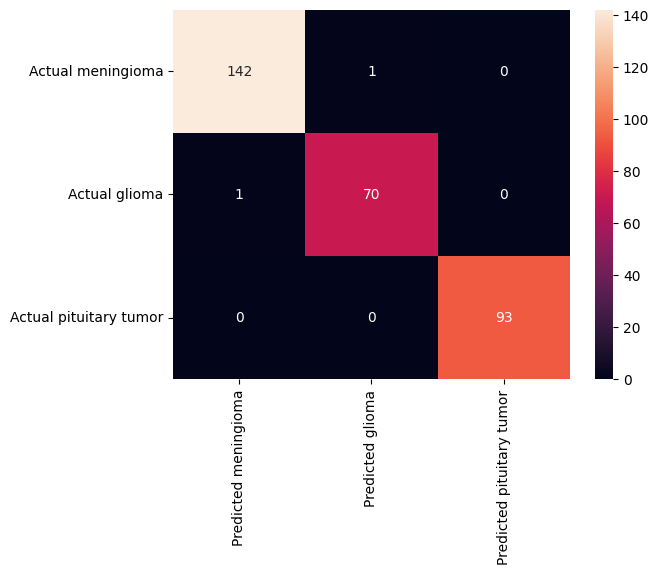

In [87]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")